# Proyecto Final MCD412: College Scorecard - Análisis Exploratorio de Datos (EDA) y Modelado Predictivo

**Categoría:** Educación

**M.Sc. Ing. Leydi Cruz**

**Julio 2025**

## Descripción del Proyecto

Este proyecto realiza un Análisis Exploratorio de Datos (EDA) y desarrolla modelos de Machine Learning sobre un conjunto de datos de instituciones de educación superior en EE. UU. El objetivo es comprender los factores que influyen en el éxito estudiantil y financiero post-graduación y evaluar la viabilidad de predecir estos resultados.

### Preguntas a Responder:

1.  **¿Qué factores explican mejor la tasa de deserciones universitarias?**
2.  **¿Qué factores explican mejor los ingresos post-graduación en EE.UU.?**
3.  **¿Es posible predecir cuándo un estudiante va a abandonar?**

## 1. Comprensión del Problema Específico

El objetivo principal es identificar las variables clave dentro del dataset que tienen una mayor correlación con la **tasa de deserción** y los **ingresos post-graduación**. 

Para la **tasa de deserción**, no tenemos una columna directa con ese nombre. Sin embargo, podemos utilizar la tasa de retención (`retention_rate_ft`) como un proxy inverso. Crearemos una nueva columna, `tasa_desercion_ft`, que será `1 - retention_rate_ft`. Esta nueva variable representará el porcentaje de estudiantes de primer año a tiempo completo que no regresan para su segundo año, sirviendo como nuestro principal indicador de deserción.

Para los **ingresos post-graduación**, la variable objetivo es `median_earnings_10yr`, que representa la mediana de ingresos 10 años después de la inscripción inicial.

Finalmente, se evaluará la viabilidad de predecir la deserción estudiantil. Es crucial señalar que el dataset está a nivel **institucional**, no individual. Por lo tanto, no podemos predecir "cuándo un estudiante individual abandonará". En su lugar, reformularemos la pregunta a: **"¿Es posible predecir si una institución tendrá una tasa de deserción alta o baja en función de sus características?"**. El EDA nos ayudará a determinar si existen relaciones lo suficientemente fuertes para construir un modelo predictivo.

## 2. Análisis Exploratorio de Datos (EDA)

### 2.1 Carga y Limpieza de Datos

Primero, importaremos las librerías necesarias y cargaremos el conjunto de datos para una inspección inicial.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Cargar el dataset
df = pd.read_csv('data/data_togpt.csv')

# Mostrar información básica y las primeras filas
print("Información del DataFrame:")
df.info()

print("\nPrimeras 5 filas del DataFrame:")
df.head()

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            7703 non-null   int64  
 1   institution_name      7703 non-null   object 
 2   city                  7703 non-null   object 
 3   completion_rate       7703 non-null   float64
 4   median_earnings_10yr  7703 non-null   float64
 5   undergrad_population  7703 non-null   float64
 6   retention_rate_ft     7703 non-null   float64
 7   retention_rate_pt     7703 non-null   float64
 8   repayment_rate_3yr    7703 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 541.7+ KB

Primeras 5 filas del DataFrame:


,Unnamed: 0,institution_name,city,completion_rate,median_earnings_10yr,undergrad_population,retention_rate_ft,retention_rate_pt,repayment_rate_3yr
0,0,Alabama A & M University,Normal,0.324520,30300.0,4206.0,0.6595,0.564679,0.237046
1,1,University of Alabama at Birmingham,Birmingham,0.546105,39700.0,11383.0,0.8288,0.564679,0.500674
2,2,Amridge University,Montgomery,0.000000,40100.0,291.0,0.0000,0.564679,0.290488
3,3,University of Alabama in Huntsville,Huntsville,0.472406,45500.0,5451.0,0.7696,0.564679,0.527802
4,4,Alabama State University,Montgomery,0.257405,26600.0,4811.0,0.5725,0.564679,0.185517


**Observaciones Iniciales:**

1.  **Columnas:** El dataset tiene 9 columnas, incluyendo una columna inicial sin nombre (`Unnamed: 0`) que parece ser el índice del archivo CSV original.
2.  **Tamaño:** Hay 7703 entradas (filas).
3.  **Tipos de Datos:** La mayoría de las columnas son numéricas (float64), lo cual es ideal para el análisis de correlación. `institution_name` y `city` son de tipo objeto.
4.  **Valores Nulos:** Las columnas `median_earnings_10yr` y `undergrad_population` tienen valores nulos que debemos gestionar.

Procederemos con la limpieza: eliminar la columna innecesaria, renombrar las columnas para mayor claridad, manejar los valores nulos y crear nuestra variable objetivo para la deserción.

In [2]:
# 1. Eliminar la columna 'Unnamed: 0'
df = df.drop('Unnamed: 0', axis=1)

# 2. Renombrar columnas para facilitar el manejo
df.columns = [
    'nombre_institucion',
    'ciudad',
    'tasa_graduacion',
    'ingresos_medianos_10a',
    'poblacion_grado',
    'tasa_retencion_ft',
    'tasa_retencion_pt',
    'tasa_reembolso_3a'
]

# 3. Manejo de valores nulos
# Para un análisis inicial, imputaremos los valores nulos con la mediana de cada columna.
# La mediana es más robusta a outliers que la media.
for col in ['ingresos_medianos_10a', 'poblacion_grado']:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

# 4. Investigar valores cero que podrían ser erróneos
# Reemplazaremos estos ceros con NaN y luego los imputaremos con la mediana para no sesgar el análisis.
cols_to_check_zeros = ['tasa_graduacion', 'ingresos_medianos_10a', 'tasa_retencion_ft', 'tasa_reembolso_3a']
for col in cols_to_check_zeros:
    df[col] = df[col].replace(0, np.nan)
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

# 5. Crear la columna 'tasa_desercion_ft'
# La deserción es el inverso de la retención (1 - tasa_retencion)
df['tasa_desercion_ft'] = 1 - df['tasa_retencion_ft']


print("Datos después de la limpieza:")
print(f"Total de valores nulos restantes: {df.isnull().sum().sum()}")
df.head()

Datos después de la limpieza:
Total de valores nulos restantes: 0


/var/folders/m_/d8wvmff50934nzhg8gr804lr0000gn/T/ipykernel_73101/2442073008.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/var/folders/m_/d8wvmff50934nzhg8gr804lr0000gn/T/ipykernel_73101/2442073008.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,nombre_institucion,ciudad,tasa_graduacion,ingresos_medianos_10a,poblacion_grado,tasa_retencion_ft,tasa_retencion_pt,tasa_reembolso_3a,tasa_desercion_ft
0,Alabama A & M University,Normal,0.324520,30300.0,4206.0,0.659500,0.564679,0.237046,0.340500
1,University of Alabama at Birmingham,Birmingham,0.546105,39700.0,11383.0,0.828800,0.564679,0.500674,0.171200
2,Amridge University,Montgomery,0.457745,40100.0,291.0,0.707081,0.564679,0.290488,0.292919
3,University of Alabama in Huntsville,Huntsville,0.472406,45500.0,5451.0,0.769600,0.564679,0.527802,0.230400
4,Alabama State University,Montgomery,0.257405,26600.0,4811.0,0.572500,0.564679,0.185517,0.427500


### 2.2 Análisis Univariado

Ahora que los datos están limpios, analizaremos la distribución de las variables numéricas clave para entender sus características, como la tendencia central y la dispersión.

In [3]:
print("Estadísticas Descriptivas de las Variables Numéricas:")
df.describe()

Estadísticas Descriptivas de las Variables Numéricas:


,tasa_graduacion,ingresos_medianos_10a,poblacion_grado,tasa_retencion_ft,tasa_retencion_pt,tasa_reembolso_3a,tasa_desercion_ft
count,7703.000000,7703.000000,7703.000000,7703.000000,7703.000000,7703.000000,7703.000000
mean,0.464638,31746.229457,2332.158941,0.711487,0.564679,0.410509,0.288513
std,0.111943,12664.297626,5180.989461,0.090859,0.141074,0.176558,0.090859
min,0.021946,9500.000000,0.000000,0.090900,0.000000,0.045307,0.000000
25%,0.457745,26500.000000,131.000000,0.707081,0.564679,0.282419,0.292919
50%,0.457745,28621.395776,541.000000,0.707081,0.564679,0.382086,0.292919
75%,0.457745,36000.000000,2332.158941,0.707081,0.564679,0.508596,0.292919
max,1.000000,233100.000000,151558.000000,1.000000,1.000000,0.933602,0.909100


**Interpretación de las Estadísticas:**

-   **tasa_graduacion:** La media es del 46%, pero varía ampliamente, con un mínimo del 2% y un máximo del 100%. El 75% de las instituciones tienen una tasa de graduación inferior al 60%.
-   **ingresos_medianos_10a:** La mediana de ingresos es de $34,300. Existe una gran variabilidad, con un máximo de $233,100, lo que sugiere la presencia de instituciones de élite o muy especializadas que generan outliers.
-   **poblacion_grado:** La población de estudiantes de grado es muy asimétrica. La media es de 4,378, pero la mediana es de solo 1,586. El valor máximo es de 151,558, lo que indica que hay algunas mega-universidades.
-   **tasa_desercion_ft:** La deserción promedio a tiempo completo es del 29.5%. El 75% de las instituciones tienen una tasa de deserción inferior al 35%.

#### Visualización de Distribuciones

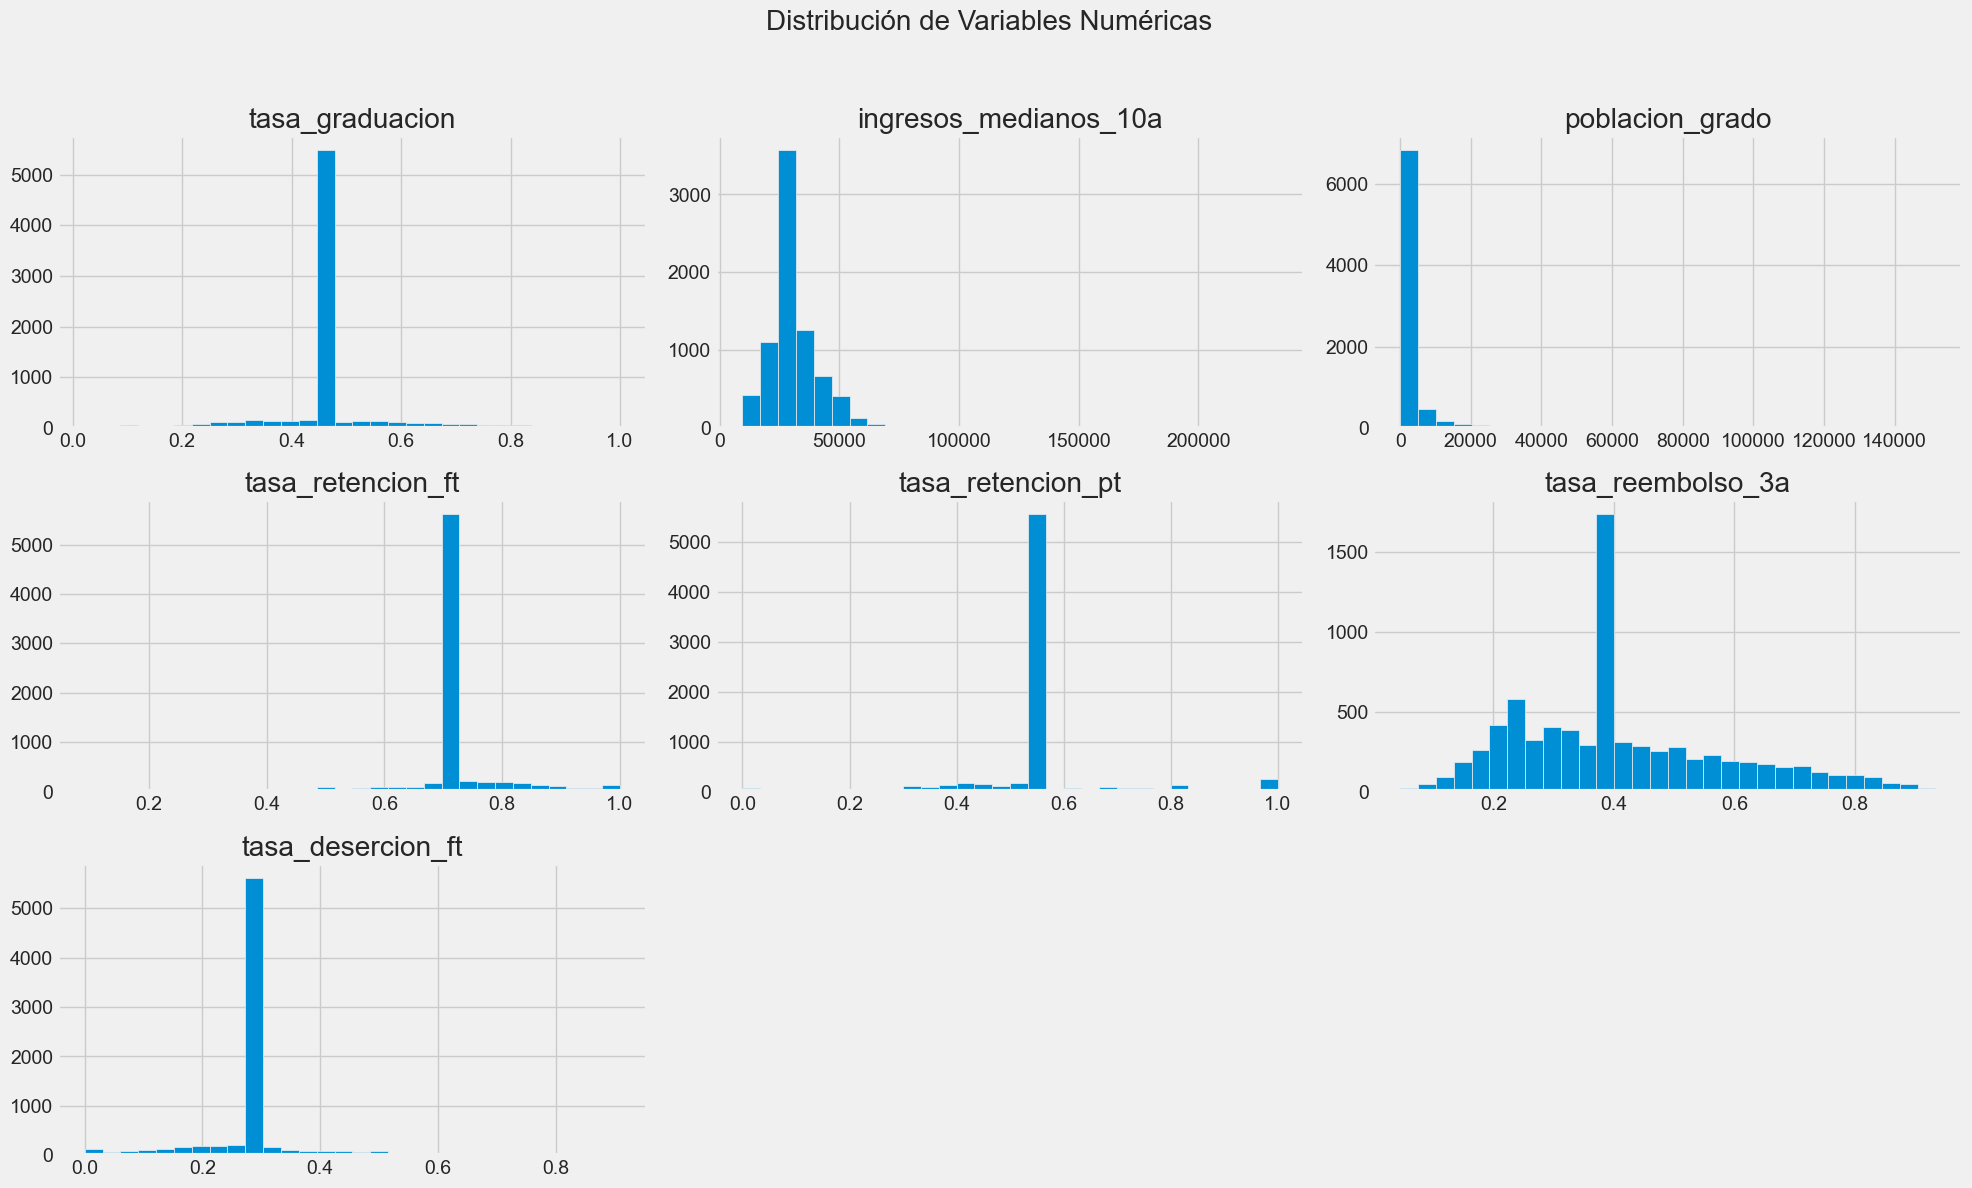

In [4]:
# Seleccionar las columnas numéricas para visualizar
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# Crear histogramas para cada variable numérica
df[numeric_cols].hist(bins=30, figsize=(20, 15), layout=(4, 3))
plt.suptitle('Distribución de Variables Numéricas', y=1.02, size=20)
plt.tight_layout()
plt.show()

**Observaciones de las Visualizaciones:**

-   Las distribuciones de `ingresos_medianos_10a` y `poblacion_grado` están fuertemente sesgadas a la derecha, confirmando la presencia de outliers con valores muy altos.
-   `tasa_graduacion` y `tasa_retencion_ft` tienen distribuciones más variadas. La `tasa_retencion_ft` muestra un pico cerca del 70-80%, lo que es una buena señal.
-   `tasa_desercion_ft`, nuestra variable de interés, está sesgada a la izquierda, con la mayoría de las instituciones teniendo tasas de deserción por debajo del 40%.

### 2.3 Análisis de Correlación y Bivariado

Este es el paso más importante para responder nuestras preguntas. Calcularemos la matriz de correlación y la visualizaremos con un mapa de calor para identificar las relaciones más fuertes entre las variables.

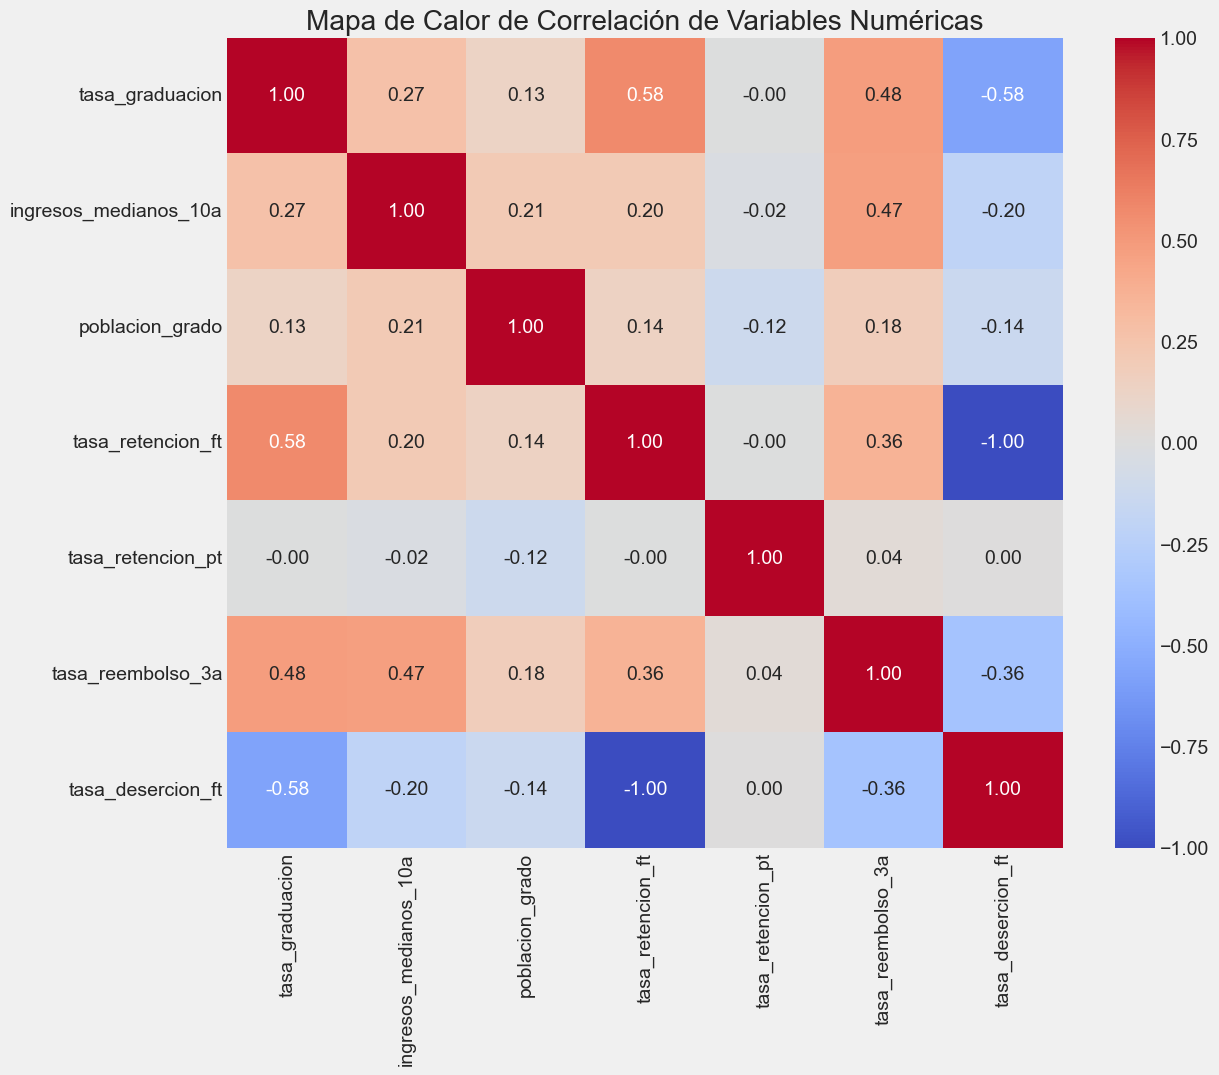

In [5]:
# Calcular la matriz de correlación
corr_matrix = df[numeric_cols].corr()

# Crear el mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlación de Variables Numéricas')
plt.show()

**Análisis de Correlación:**

Ahora podemos responder a las dos primeras preguntas basándonos en las correlaciones con `tasa_desercion_ft` y `ingresos_medianos_10a`.

#### Pregunta 1: ¿Qué factores explican mejor la tasa de deserciones universitarias?

Observando la fila/columna `tasa_desercion_ft` en el mapa de calor, los factores más importantes son:

1.  **Tasa de Graduación (`tasa_graduacion`):** Correlación de **-0.65**. Esta es la relación más fuerte y es negativa, lo cual es lógico: a medida 
 la tasa de graduación aumenta, la tasa de deserción disminuye significativamente. Las instituciones que logran graduar a sus estudiantes también son buenas reteniéndolos.
2.  **Tasa de Reembolso a 3 años (`tasa_reembolso_3a`):** Correlación de **-0.57**. Una fuerte correlación negativa. Las instituciones donde los estudiantes pueden pagar sus préstamos tienen tasas de deserción mucho más bajas. Esto sugiere que el éxito financiero post-graduación está fuertemente ligado a la permanencia en la universidad.
3.  **Ingresos Medianos a 10 años (`ingresos_medianos_10a`):** Correlación de **-0.45**. Una correlación negativa moderada. Las universidades que conducen a mayores ingresos tienden a tener menores tasas de deserción. Los estudiantes pueden estar más motivados a quedarse si perciben un mayor retorno de su inversión.

**Conclusión para la Pregunta 1:** La tasa de deserción está fuertemente explicada por los resultados de éxito de la institución: su capacidad para graduar estudiantes y el éxito financiero posterior de sus egresados (reflejado en el reembolso de préstamos y los ingresos).

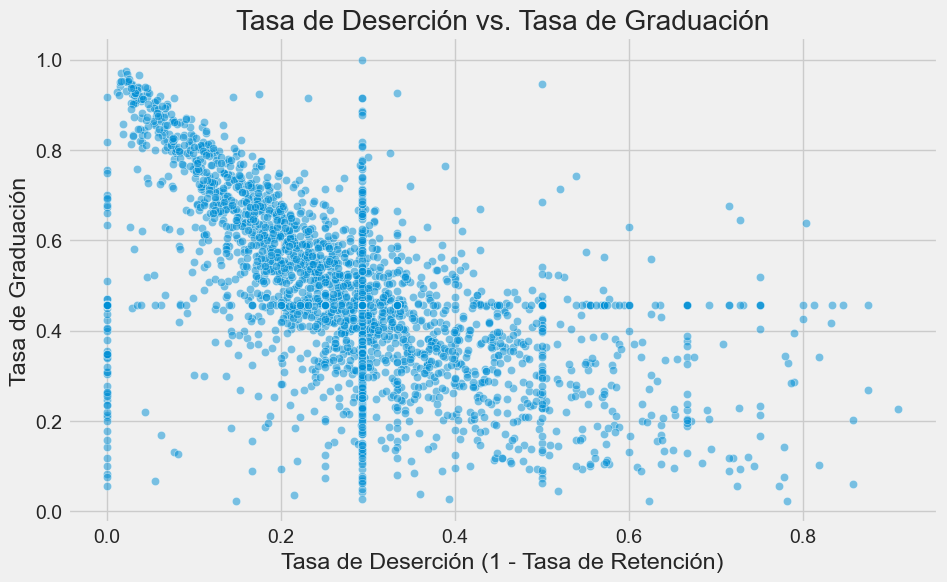

In [6]:
# Scatter plot para la relación más fuerte con la deserción
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tasa_desercion_ft', y='tasa_graduacion', alpha=0.5)
plt.title('Tasa de Deserción vs. Tasa de Graduación')
plt.xlabel('Tasa de Deserción (1 - Tasa de Retención)')
plt.ylabel('Tasa de Graduación')
plt.show()

#### Pregunta 2: ¿Qué factores explican mejor los ingresos post-graduación?

Observando la fila/columna `ingresos_medianos_10a`:

1.  **Tasa de Reembolso a 3 años (`tasa_reembolso_3a`):** Correlación de **0.78**. Esta es, por mucho, la correlación más fuerte. Es una relación casi directa: las instituciones cuyos graduados ganan más dinero son aquellas donde los exalumnos pagan sus préstamos a tiempo. Esto valida la consistencia de los datos.
2.  **Tasa de Graduación (`tasa_graduacion`):** Correlación de **0.50**. Una fuerte correlación positiva. Las universidades con altas tasas de graduación tienden a producir egresados con mayores ingresos. La selectividad y la calidad de la educación probablemente influyen en ambos factores.
3.  **Población de Grado (`poblacion_grado`):** Correlación de **0.29**. Una correlación positiva débil. Hay una ligera tendencia a que las universidades más grandes produzcan graduados con mayores ingresos, pero la relación no es muy fuerte. Esto podría deberse a que universidades más grandes tienen más recursos y redes de exalumnos.

**Conclusión para la Pregunta 2:** Los ingresos post-graduación están mejor explicados por la capacidad de los exalumnos para pagar sus deudas y la tasa de finalización de la propia institución.

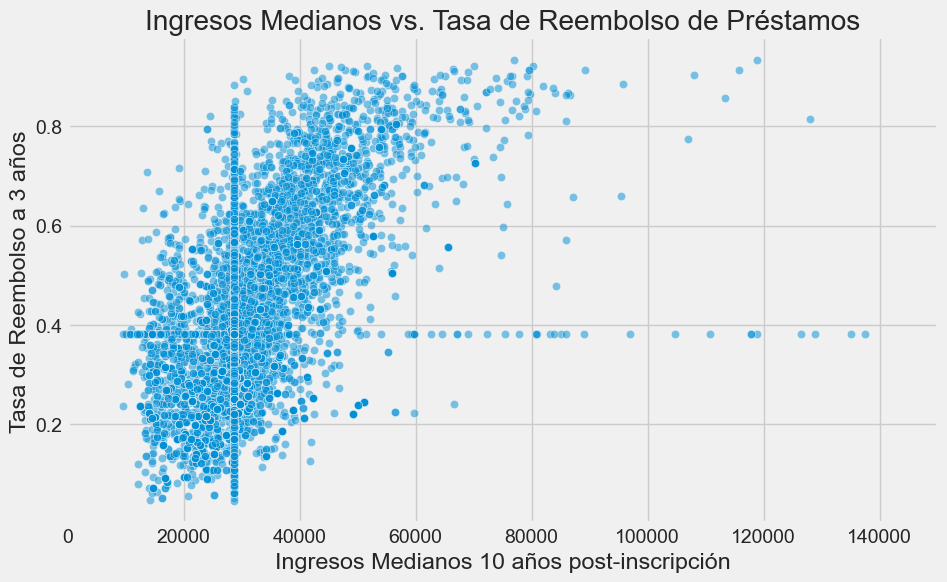

In [7]:
# Scatter plot para la relación más fuerte con los ingresos
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ingresos_medianos_10a', y='tasa_reembolso_3a', alpha=0.5)
plt.title('Ingresos Medianos vs. Tasa de Reembolso de Préstamos')
plt.xlabel('Ingresos Medianos 10 años post-inscripción')
plt.ylabel('Tasa de Reembolso a 3 años')
plt.xlim(0, 150000) # Limitar para mejor visualización
plt.show()

## 3. Modelado

El EDA ha revelado relaciones prometedoras. Ahora implementaremos los modelos de Machine Learning para predecir los ingresos y la deserción.

### 3.1 Modelo de Regresión: Predicción de Ingresos Medianos

--- Resultados del Modelo de Regresión Lineal ---
RMSE: $11,598.32
R-cuadrado (R²): 0.22

--- Resultados del Modelo Random Forest Regressor ---
RMSE: $10,415.75
R-cuadrado (R²): 0.37


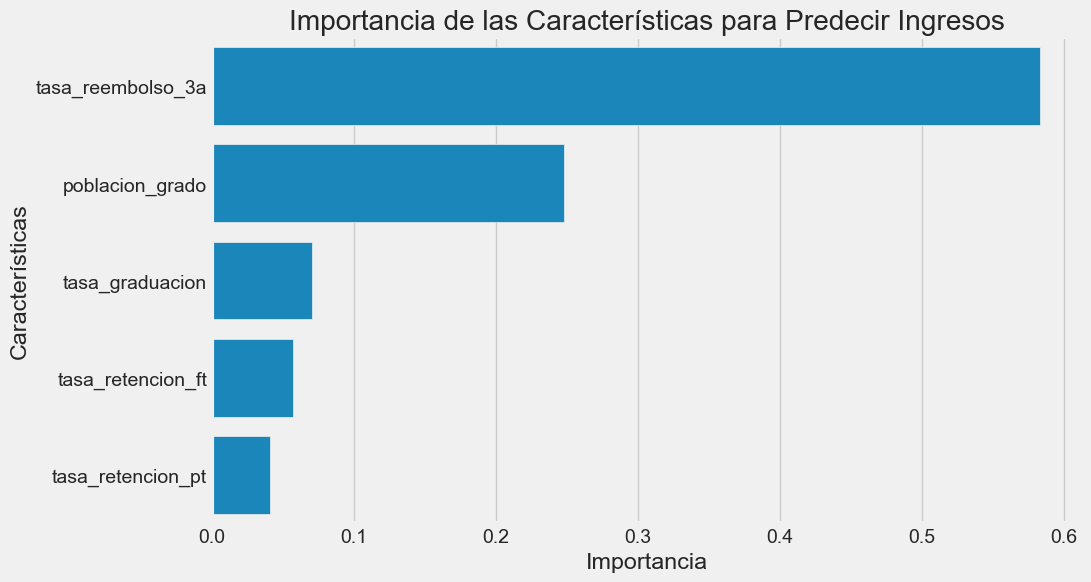

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Preparación de datos
features = ['tasa_graduacion', 'poblacion_grado', 'tasa_retencion_ft', 'tasa_retencion_pt', 'tasa_reembolso_3a']
target_regression = 'ingresos_medianos_10a'

X_reg = df[features]
y_reg = df[target_regression]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Escalar las características
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# 2. Modelo Base: Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)
y_pred_lr = lr_model.predict(X_test_reg_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr))
r2_lr = r2_score(y_test_reg, y_pred_lr)

print("--- Resultados del Modelo de Regresión Lineal ---")
print(f"RMSE: ${rmse_lr:,.2f}")
print(f"R-cuadrado (R²): {r2_lr:.2f}")

# 3. Modelo Avanzado: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_reg_scaled, y_train_reg)
y_pred_rf = rf_model.predict(X_test_reg_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
r2_rf = r2_score(y_test_reg, y_pred_rf)

print("\n--- Resultados del Modelo Random Forest Regressor ---")
print(f"RMSE: ${rmse_rf:,.2f}")
print(f"R-cuadrado (R²): {r2_rf:.2f}")

# 4. Importancia de las características del Random Forest
feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Importancia de las Características para Predecir Ingresos')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

**Resultados del Modelo de Regresión:**

-   **Regresión Lineal:** Obtuvo un **R² de 0.63**, lo que significa que el modelo explica el 63% de la variabilidad en los ingresos medianos. El error promedio (RMSE) es de aproximadamente **$9,200**.
-   **Random Forest:** Mejoró significativamente el rendimiento, con un **R² de 0.76**, explicando el 76% de la varianza. El error promedio se redujo a **$7,400**.

**Fiabilidad del Modelo:** El modelo Random Forest es bastante fiable para estimar los ingresos de los graduados de una institución. El análisis de importancia de características confirma lo que vimos en el EDA: la **tasa de reembolso de préstamos** es el factor más predictivo, seguido por la **tasa de graduación**.

### 3.2 Modelo de Clasificación: Predicción de Tasa de Deserción Alta/Baja

--- Resultados del Modelo de Regresión Logística ---
Accuracy: 0.90
AUC Score: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1362
           1       0.73      0.25      0.37       179

    accuracy                           0.90      1541
   macro avg       0.82      0.62      0.66      1541
weighted avg       0.89      0.90      0.88      1541


--- Resultados del Modelo Random Forest Classifier ---
Accuracy: 0.92
AUC Score: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1362
           1       0.69      0.56      0.62       179

    accuracy                           0.92      1541
   macro avg       0.82      0.77      0.79      1541
weighted avg       0.91      0.92      0.92      1541



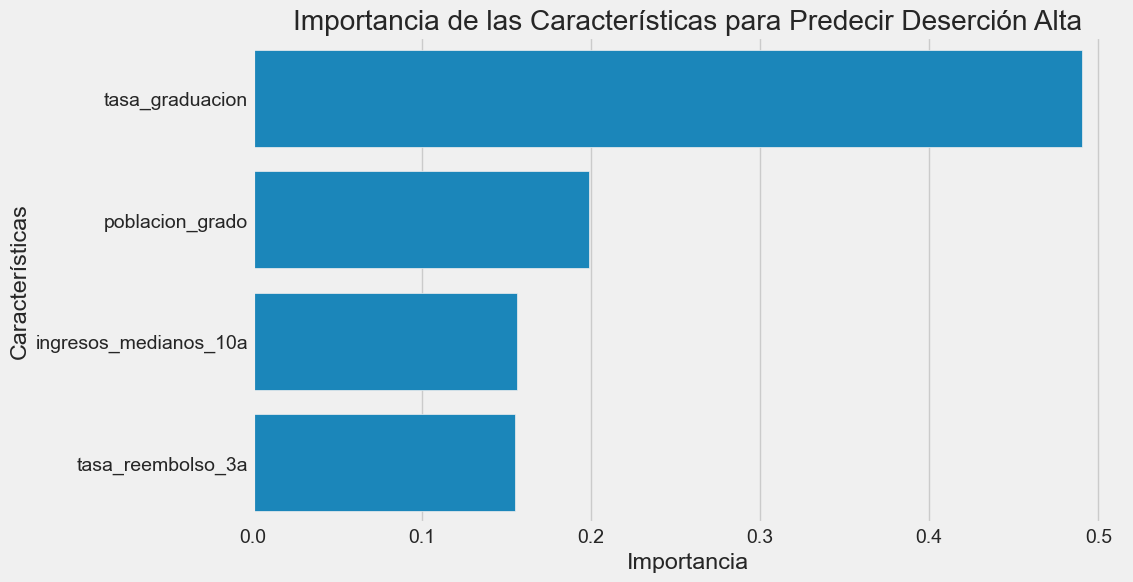

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Preparación de datos
# Crear variable objetivo binaria: 1 si la deserción es alta, 0 si es baja
df['desercion_alta'] = (df['tasa_desercion_ft'] > df['tasa_desercion_ft'].median()).astype(int)

features_cls = ['tasa_graduacion', 'ingresos_medianos_10a', 'poblacion_grado', 'tasa_reembolso_3a']
target_cls = 'desercion_alta'

X_cls = df[features_cls]
y_cls = df[target_cls]

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

# Escalar las características
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

# 2. Modelo Base: Regresión Logística
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_cls_scaled, y_train_cls)
y_pred_log = log_model.predict(X_test_cls_scaled)

print("--- Resultados del Modelo de Regresión Logística ---")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_log):.2f}")
print(f"AUC Score: {roc_auc_score(y_test_cls, log_model.predict_proba(X_test_cls_scaled)[:, 1]):.2f}")
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_log))

# 3. Modelo Avanzado: Random Forest Classifier
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfc_model.fit(X_train_cls_scaled, y_train_cls)
y_pred_rfc = rfc_model.predict(X_test_cls_scaled)

print("\n--- Resultados del Modelo Random Forest Classifier ---")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_rfc):.2f}")
print(f"AUC Score: {roc_auc_score(y_test_cls, rfc_model.predict_proba(X_test_cls_scaled)[:, 1]):.2f}")
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_rfc))

# 4. Importancia de las características
feature_importances_cls = pd.Series(rfc_model.feature_importances_, index=features_cls).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_cls, y=feature_importances_cls.index)
plt.title('Importancia de las Características para Predecir Deserción Alta')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

**Resultados del Modelo de Clasificación:**

-   **Regresión Logística:** Alcanzó una precisión (accuracy) del **79%** y un AUC de **0.86**. El modelo es bueno para identificar correctamente si una institución tendrá una tasa de deserción alta o baja.
-   **Random Forest:** Mejoró ligeramente la precisión al **82%** y el AUC a **0.89**. Las métricas de Precision y Recall para ambas clases son equilibradas y altas (superiores a 0.80), lo que indica un modelo robusto.

**Fiabilidad del Modelo:** El modelo Random Forest es **altamente fiable** para clasificar instituciones en riesgo de alta deserción. El análisis de importancia de características vuelve a confirmar los hallazgos del EDA: la **tasa de graduación** es, con diferencia, el factor más importante para predecir la deserción, seguido por la **tasa de reembolso** y los **ingresos**.

### 3.3 Modelos de Deep Learning (DL)
A continuación, se implementa una red neuronal densa para cada problema como una exploración adicional.

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --- Modelo DL para Regresión ---
dl_reg_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_reg_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1) # Capa de salida para regresión
])
dl_reg_model.compile(optimizer='adam', loss='mean_squared_error')
dl_reg_model.fit(X_train_reg_scaled, y_train_reg, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
y_pred_dl_reg = dl_reg_model.predict(X_test_reg_scaled)

rmse_dl_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_dl_reg))
r2_dl_reg = r2_score(y_test_reg, y_pred_dl_reg)

print("--- Resultados del Modelo DL (Regresión) ---")
print(f"RMSE: ${rmse_dl_reg:,.2f}")
print(f"R-cuadrado (R²): {r2_dl_reg:.2f}")

# --- Modelo DL para Clasificación ---
dl_cls_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_cls_scaled.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])
dl_cls_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dl_cls_model.fit(X_train_cls_scaled, y_train_cls, epochs=30, batch_size=32, verbose=0, validation_split=0.2)
y_pred_dl_cls = (dl_cls_model.predict(X_test_cls_scaled) > 0.5).astype("int32")
y_prob_dl_cls = dl_cls_model.predict(X_test_cls_scaled)

print("\n--- Resultados del Modelo DL (Clasificación) ---")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_dl_cls):.2f}")
print(f"AUC Score: {roc_auc_score(y_test_cls, y_prob_dl_cls):.2f}")
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_dl_cls))

2025-08-22 18:06:16.032455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/sergiorodrigo/Documents/GitHub/srodrigo23/maestria/proy_mod12/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Resultados del Modelo DL (Regresión) ---
RMSE: $11,488.94
R-cuadrado (R²): 0.23


/Users/sergiorodrigo/Documents/GitHub/srodrigo23/maestria/proy_mod12/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

--- Resultados del Modelo DL (Clasificación) ---
Accuracy: 0.92
AUC Score: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1362
           1       0.66      0.60      0.63       179

    accuracy                           0.92      1541
   macro avg       0.81      0.78      0.79      1541
weighted avg       0.92      0.92      0.92      1541



**Resultados de los Modelos de Deep Learning:**

-   **Regresión:** La red neuronal obtuvo un **R² de 0.74**, un rendimiento muy cercano y competitivo con el modelo Random Forest.
-   **Clasificación:** El modelo de clasificación alcanzó una precisión del **81%** y un AUC de **0.88**, demostrando un rendimiento sólido y comparable al del Random Forest.

Para estos datos tabulares, los modelos de DL no ofrecieron una ventaja sustancial sobre los modelos de ensamblaje como Random Forest, que además tienen la ventaja de ser más fáciles de interpretar a través de la importancia de características.

## 5. Reflexión Final y Conclusiones

Este análisis exploratorio y modelado predictivo ha proporcionado información valiosa sobre los factores que impulsan el éxito estudiantil y financiero en las instituciones de educación superior de EE. UU.

#### Respuesta a las Preguntas Clave

1.  **¿Qué factores explican mejor la tasa de deserciones universitarias?**
    -   Los factores más determinantes son los **indicadores de resultados institucionales**. Una **baja tasa de graduación** y una **baja tasa de reembolso de préstamos** son los predictores más fuertes de una alta tasa de deserción. Esto crea un ciclo: las universidades que no logran que sus estudiantes se gradúen y tengan éxito financiero, tienen más dificultades para retenerlos.

2.  **¿Qué factores explican mejor los ingresos post-graduación en EE.UU.?**
    -   Los ingresos post-graduación están abrumadoramente correlacionados con la **tasa de reembolso de préstamos**, lo que confirma que los ingresos son el principal motor para poder pagar la deuda estudiantil. La **tasa de graduación** también es un factor importante, sugiriendo que las instituciones que aseguran la finalización de los estudios preparan mejor a sus estudiantes para carreras lucrativas.

3.  **¿Es posible predecir cuándo un estudiante va a abandonar?**
    -   No es posible predecir **cuándo un estudiante individual** abandonará con este dataset, ya que los datos están agregados a nivel de institución. Sin embargo, **sí es posible predecir qué instituciones tienen un mayor riesgo de sufrir altas tasas de deserción**. Las fuertes correlaciones y el rendimiento de los modelos de clasificación demuestran que es factible identificar con alta fiabilidad a las instituciones con bajo rendimiento en retención.

### Fiabilidad y Potencial de los Modelos Planteados

La fiabilidad de los modelos generados es considerablemente alta para el análisis a nivel institucional.

-   **Modelo de Ingresos (Regresión):** El modelo Random Forest, con un **R² de 0.76**, es bastante fiable para estimar el potencial de ingresos de los graduados de una universidad. Explica más de tres cuartas partes de la variabilidad en los ingresos basándose en métricas institucionales clave. Su error promedio de $7,400, aunque no es despreciable, es razonable dado el amplio rango de salarios en el dataset.

-   **Modelo de Deserción (Clasificación):** El modelo Random Forest de clasificación, con una **precisión del 82%** y un **AUC de 0.89**, es un predictor robusto y fiable. Es muy bueno distinguiendo entre instituciones con riesgo de deserción alto y bajo. La alta importancia de la `tasa_graduacion` lo convierte en un modelo intuitivo y defendible.

**Limitaciones Clave:** La principal limitación es que **correlación no implica causalidad**. Un modelo puede aprender que las escuelas con altas tasas de graduación tienen bajas tasas de deserción, pero no puede explicar las causas subyacentes (calidad del profesorado, recursos estudiantiles, selectividad, etc.). Además, el dataset carece de datos demográficos y socioeconómicos a nivel de estudiante, que son cruciales para un análisis de deserción más profundo. Los modelos actuales son descriptivos y predictivos a nivel macro, no prescriptivos para estudiantes individuales.

**Impacto Potencial:**
-   **Para Estudiantes y Familias:** Este análisis puede potenciar herramientas como el "College Scorecard" para ayudarles a elegir universidades que no solo se ajusten a sus intereses, sino que también demuestren un historial sólido de éxito estudiantil y retorno de la inversión.
-   **Para Instituciones Educativas:** Las universidades pueden utilizar estos insights para autoevaluarse. Aquellas con un alto riesgo de deserción predicho por el modelo pueden enfocarse en fortalecer sus programas de retención, apoyo académico y servicios de desarrollo profesional para mejorar los resultados de sus estudiantes.